# Project part E

Static object tracking through multiple frames using SAM and DINOv2. This means no open vocabulary queries.

## Dependencies and Imports

In [1]:
# Install dependencies
!pip install --upgrade pip
!pip install torch==2.4.0+cu121 torchvision==0.19.0+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.44.0 huggingface-hub==0.24.0 pillow numpy opencv-python open3d ipympl rerun-sdk[notebook]

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
# Import required libraries
import os
from typing import Dict, List, Optional
import cv2
import numpy as np
import matplotlib.cm as cm
from PIL import Image
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


# Import lab utility functions
from lab_utils.data_utils import get_frame_list, load_camera_poses, validate_and_align_frame_data
from lab_utils.tsdf_utils import build_tsdf_point_cloud
from lab_utils.model_loaders import load_sam_model, load_clip_model


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/jovyan/EmbodiedAIProject/project/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Configuration

In [3]:
class Config:
    # Scene Configuration
    SCENE_ID = "47333473"
    BASE_PATH = f"ARKitScenesData/{SCENE_ID}/{SCENE_ID}_frames"
    RGB_PATH = os.path.join(BASE_PATH, "lowres_wide")
    DEPTH_PATH = os.path.join(BASE_PATH, "lowres_depth")
    INTRINSICS_PATH = os.path.join(BASE_PATH, "lowres_wide_intrinsics")
    TRAJ_FILE_PATH = os.path.join(BASE_PATH, "lowres_wide.traj")
    
    # Project Configuration
    PROJECT_CONFIG = {
        'frame_skip': 7,                                  
        'max_frames': 40,                                  
        'grid_size': 6,                                    
        'sam_confidence_threshold': 0.5,                   
        'clip_model': 'openai/clip-vit-base-patch32',      
        'example_viz_index': 29,                          
        'padding_ratio_image_crops': 0.1                   
    }
    
    # TSDF Configuration (for visualization)
    TSDF_CONFIG = {
        'frame_skip': 3,
        'depth_scale': 1000.0,
        'depth_trunc': 7.0,
        'voxel_size': 0.04,
        'batch_size': 20,
        'max_frames': 1000,
        'volume_length': 30.0,
        'resolution': 512,
    }
    
    # Rerun Viewer Dimensions
    RERUN_WIDTH, RERUN_HEIGHT = 1200, 700

# Create and validate config
config = Config()

## SAM

Here we use SAM with a grid of point promps, same as in Lab2 to generate a set of proposals.

Each proposal has:
- mask
- area
- point
- confidence

In [4]:
def generate_sam_proposals_project(image: Image.Image,
                          sam_model,
                          sam_processor,
                          device: str,
                          grid_size: int = 6,
                          confidence_threshold: float = 0.5) -> List[Dict]:
    """Generate object proposals using SAM with a grid of point prompts."""
    width, height = image.size
    # Generate grid of point prompts
    x_points = np.linspace(width * 0.1, width * 0.9, grid_size)
    y_points = np.linspace(height * 0.1, height * 0.9, grid_size)
    
    proposals = []
    processed_masks = []
    
    tqdm.write(f"Generating SAM proposals with {grid_size}x{grid_size} grid...")
    
    for i, x in enumerate(x_points):
        for j, y in enumerate(y_points):
            input_points = [[[x, y]]]
            
            try:
                inputs = sam_processor(
                    images=image,
                    input_points=input_points,
                    return_tensors="pt"
                )
                
                inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                         for k, v in inputs.items()}
                
                with torch.no_grad():
                    outputs = sam_model(**inputs)
                
                masks = sam_processor.image_processor.post_process_masks(
                    outputs.pred_masks.cpu(),
                    inputs["original_sizes"].cpu(),
                    inputs["reshaped_input_sizes"].cpu()
                )
                
                batch_masks = masks[0]
                if len(batch_masks) == 0:
                    continue
                
                point_masks = batch_masks[0]
                if len(point_masks) == 0:
                    continue
                
                
                best_mask_idx = 0  # Default to first mask
                best_score = 0.5   # Default confidence

                
                
                if hasattr(outputs, 'iou_scores') and outputs.iou_scores is not None:
                    try:
                        iou_scores = outputs.iou_scores[0,0,:].cpu().numpy()  # TODO: Extract scores for [0][0]
                        if len(iou_scores) > 0:
                            best_mask_idx = int(np.argmax(iou_scores))  # TODO: Find index of max score
                            best_score = float(iou_scores[best_mask_idx])  # TODO: Get the actual score value
                             
                            if best_score < confidence_threshold:
                                continue
                    except:
                        pass
                
                mask = point_masks[best_mask_idx]
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().astype(bool)
                else:
                    mask_np = np.array(mask).astype(bool)
                
                # Check for duplicates
                is_duplicate = False
                for existing_mask in processed_masks:
                    overlap = np.sum(mask_np & existing_mask)
                    union = np.sum(mask_np | existing_mask)
                    if union > 0 and overlap / union > 0.8:
                        is_duplicate = True
                        break
                
                if not is_duplicate and np.sum(mask_np) > 100:
                    proposals.append({
                        'mask': mask_np,
                        'area': np.sum(mask_np),
                        'point': [x, y],
                        'confidence': best_score
                    })
                    processed_masks.append(mask_np)
                    
            except Exception as e:
                continue
    
    tqdm.write(f"Generated {len(proposals)} unique segment proposals")
    return proposals

## CLIP with bounding box

The code below uses CLIP to extract features from the segments obtained from SAM.

We create a bounding box of the mask, crop the image and use CLIP to obtain the features.

In [5]:
def extract_clip_features_from_segment(image: Image.Image,
                                  mask: np.ndarray,
                                  clip_model,
                                  clip_processor,
                                  device: str,
                                  padding_ratio: float = 0.1) -> Optional[np.ndarray]:
    """Extract CLIP features from a segmented region."""
    try:
        # Find bounding box of mask
        coords = np.where(mask)
        if len(coords[0]) == 0:
            return None
        
        
        y_min, y_max = coords[0].min(), coords[0].max()
        x_min, x_max = coords[1].min(), coords[1].max()
        
        # Your implementation here for expanding bounds and cropping
        pad_y = int((y_max - y_min) * padding_ratio)
        pad_x = int((x_max - x_min) * padding_ratio)

        y_min_exp = max(int(y_min - pad_y), 0)
        y_max_exp = min(int(y_max + pad_y), mask.shape[0])
        x_min_exp = max(int(x_min - pad_x), 0)
        x_max_exp = min(int(x_max + pad_x), mask.shape[1])

        image_crop = image.crop((int(x_min_exp), int(y_min_exp), int(x_max_exp), int(y_max_exp))) # Replace this line
                
        # Process with CLIP
        inputs = clip_processor(images=image_crop, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
            
            # Noramlize image features
            image_features = image_features/ image_features.norm(p=2, dim=-1, keepdim=True)
        
        return image_features.cpu().numpy().squeeze()
        
    except Exception as e:
        print(f"Failed to extract CLIP features: {e}")
        return None

## Visualization SAM + CLIP

Now we want to put this 2 proceses together and visualize the results in an example, as they do in Lab2 (basically same code).

### Code for visualization

In [6]:
def visualize_project_example_clip(config, frame_index: int = 29) -> Dict:
    """Project visualization: SAM proposals with CLIP semantic similarity overlays."""
    print("=" * 50)
    print("PROJECT: SEMANTIC SEGMENT ANALYSIS")
    print("=" * 50)
    print(f"Processing frame {frame_index} with text queries: 'pillow' vs 'sofa'")
    
    # Load models
    print("Loading models...")
    sam_model, sam_processor, device = load_sam_model(model_size='base')
    clip_model, clip_processor, _ = load_clip_model(device=device)
    
    # Get frame data
    frames_metadata = get_frame_list(config.RGB_PATH, config.PROJECT_CONFIG['frame_skip'])
    if frame_index >= len(frames_metadata):
        frame_index = len(frames_metadata) // 2
        print(f"Adjusted frame index to {frame_index}")
    
    frame_name = frames_metadata[frame_index]['filename']
    rgb_path = os.path.join(config.RGB_PATH, frame_name)
    
    if not os.path.exists(rgb_path):
        print(f"Frame not found: {rgb_path}")
        return {}
    
    image = Image.open(rgb_path).convert("RGB")
    print(f"Frame: {frame_name}, size: {image.size}")
    
    # Import the required functions from the notebook context
    '''
    try:
        from __main__ import generate_sam_proposals, extract_clip_features_from_segment
    except ImportError:
        print("ERROR: Could not import required functions from notebook.")
        print("Please ensure generate_sam_proposals and extract_clip_features_from_segment are defined in the notebook.")
        return {}
    '''
    # Generate SAM proposals
    # print(f"Generating SAM proposals with {config.LEVEL_A_CONFIG['grid_size']}x{config.LEVEL_A_CONFIG['grid_size']} grid...")
    proposals = generate_sam_proposals_project(
        image,
        sam_model,
        sam_processor,
        device,
        grid_size=config.PROJECT_CONFIG['grid_size'],
        confidence_threshold=config.PROJECT_CONFIG['sam_confidence_threshold']
    )
    
    print(f"Generated {len(proposals)} proposals above confidence threshold")
    
    if not proposals:
        print("No proposals generated - try lowering sam_confidence_threshold")
        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(image)
        ax.set_title(f"No SAM Proposals - {frame_name}")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        return {'frame_name': frame_name, 'proposals': [], 'has_proposals': False}
    
    # Extract CLIP features for all proposals
    print("Extracting CLIP features...")
    proposal_features = []
    for proposal in proposals:
        features = extract_clip_features_from_segment(
            image,
            proposal['mask'],
            clip_model,
            clip_processor,
            device,
            padding_ratio=config.PROJECT_CONFIG['padding_ratio_image_crops'] 
        )
        if features is not None:
            proposal_features.append({
                'proposal': proposal,
                'features': features
            })
    
    print(f"Successfully extracted features for {len(proposal_features)}/{len(proposals)} proposals")
    
    if not proposal_features:
        print("No CLIP features extracted - check segment quality")
        return {'frame_name': frame_name, 'proposals': proposals, 'proposal_features': []}
    
    # Define text queries
    text_queries = ['pillow', 'sofa']
    
    # Compute text embeddings
    print("Computing text embeddings...")
    text_embeddings = {}
    for query in text_queries:
        inputs = clip_processor(text=[query], return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            text_features = clip_model.get_text_features(**inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        text_embeddings[query] = text_features.cpu().numpy().squeeze()
    
    # Compute similarities
    similarities = {}
    for query in text_queries:
        query_similarities = []
        for pf in proposal_features:
            similarity = np.dot(text_embeddings[query], pf['features'])
            query_similarities.append(similarity)
        similarities[query] = np.array(query_similarities)
    
    # Visualization with color legend
    image_gray = image.convert('L')
    image_gray_rgb = np.stack([np.array(image_gray)] * 3, axis=-1)
    
    # Create figure with GridSpec for better layout control
    fig = plt.figure(figsize=(22, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[20, 1], hspace=0.3)
    
    # Main visualization subplots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    viridis_cmap = cm.get_cmap('viridis')
    
    for idx, query in enumerate(text_queries):
        ax = ax1 if idx == 0 else ax2
        overlay = image_gray_rgb.astype(np.float32).copy()
        
        query_sims = similarities[query]
        if len(query_sims) > 0:
            sim_min, sim_max = query_sims.min(), query_sims.max()
            if sim_max > sim_min:
                sim_normalized = (query_sims - sim_min) / (sim_max - sim_min)
            else:
                sim_normalized = np.ones_like(query_sims) * 0.5
            
            for i, pf in enumerate(proposal_features):
                mask = pf['proposal']['mask']
                similarity_score = sim_normalized[i]
                color_rgba = viridis_cmap(similarity_score)
                color_rgb = np.array(color_rgba[:3]) * 255
                alpha = 0.7
                overlay[mask] = overlay[mask] * (1 - alpha) + color_rgb * alpha
        
        ax.imshow(overlay.astype(np.uint8))
        ax.set_title(f"Semantic Response: '{query}'\n"
                    f"Similarity range: [{query_sims.min():.3f}, {query_sims.max():.3f}]", 
                    fontsize=14, fontweight='bold')
        ax.axis('off')
    
    # Add color legend spanning both columns
    cax = fig.add_subplot(gs[1, :])
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('Semantic Similarity (Normalized)', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    # Add descriptive text labels on the colorbar
    cbar.ax.text(0.1, -0.8, 'Low\n(Dark Purple)', ha='center', va='top', transform=cbar.ax.transAxes, fontsize=9)
    cbar.ax.text(0.9, -0.8, 'High\n(Yellow)', ha='center', va='top', transform=cbar.ax.transAxes, fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nSemantic Similarity Analysis:")
    for query in text_queries:
        sims = similarities[query]
        print(f"  '{query}': mean={sims.mean():.3f}, max={sims.max():.3f}, std={sims.std():.3f}")
    
    return {
        'frame_name': frame_name,
        'frame_index': frame_index,
        'proposals': proposals,
        'proposal_features': proposal_features,
        'similarities': similarities,
        'text_queries': text_queries,
        'stats': {
            'total_proposals': len(proposals),
            'successful_features': len(proposal_features),
            'queries_tested': len(text_queries)
        }
    }

### Visualization

PROJECT: SEMANTIC SEGMENT ANALYSIS
Processing frame 29 with text queries: 'pillow' vs 'sofa'
Loading models...
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading CLIP model: openai/clip-vit-base-patch32...


/home/jovyan/EmbodiedAIProject/project/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIP model loaded on device: cuda
Selected 78 frames from 540 total
Frame: 47333473_58548.551.png, size: (256, 192)
Generating SAM proposals with 6x6 grid...
Generated 13 unique segment proposals
Generated 13 proposals above confidence threshold
Extracting CLIP features...
Successfully extracted features for 13/13 proposals
Computing text embeddings...


/tmp/ipykernel_34037/2232323049.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap('viridis')
/tmp/ipykernel_34037/2232323049.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


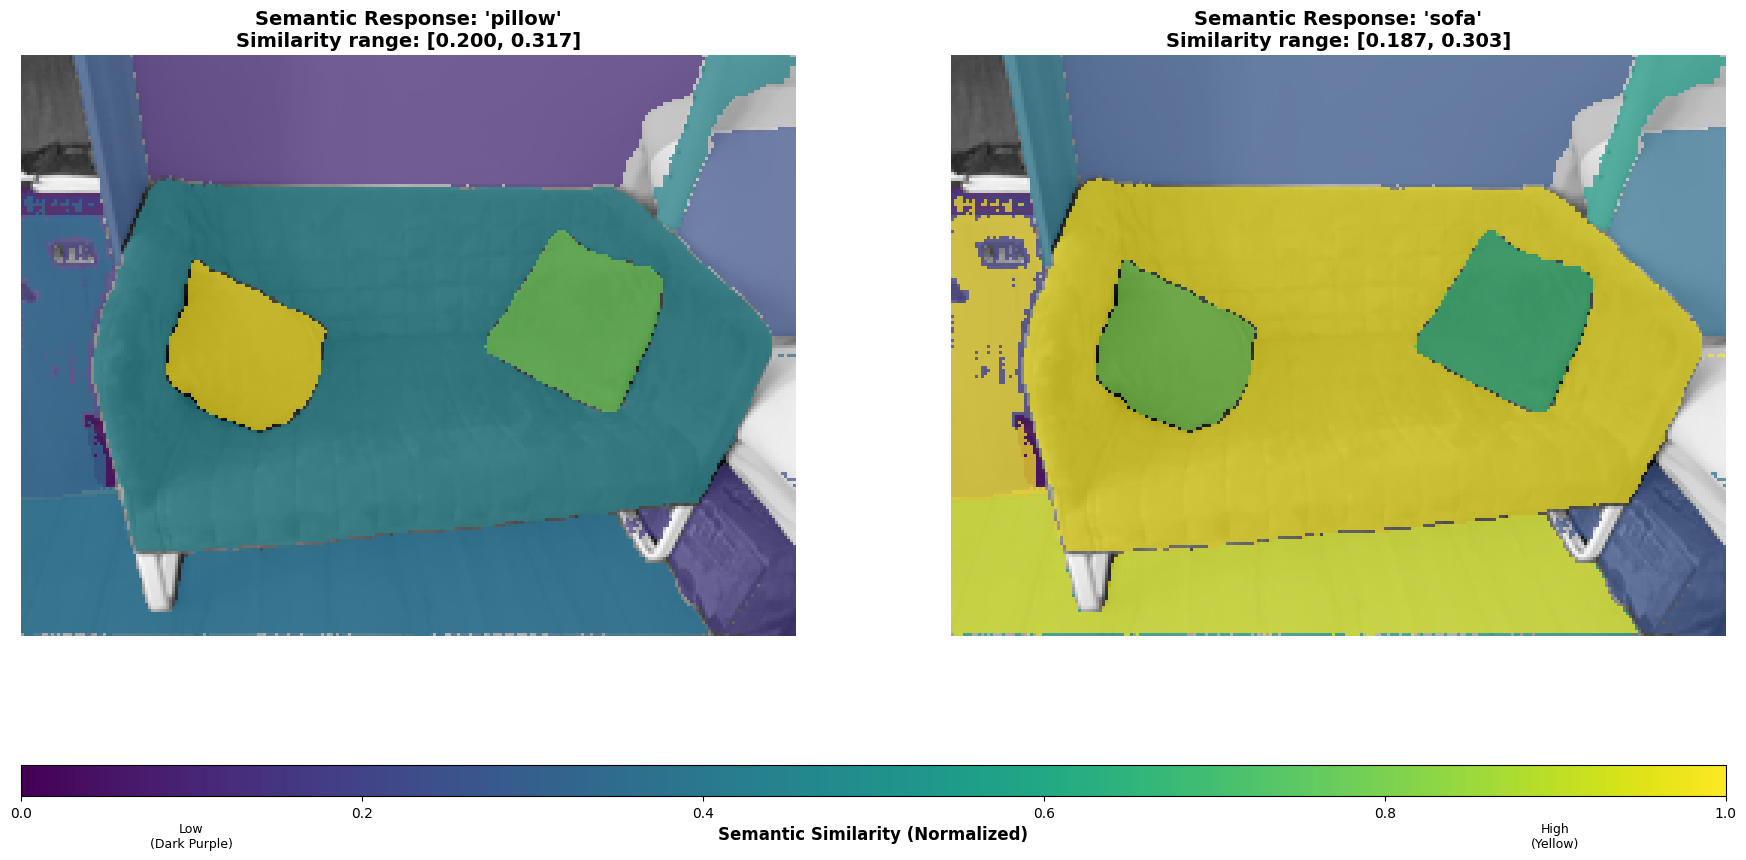


Semantic Similarity Analysis:
  'pillow': mean=0.240, max=0.317, std=0.032
  'sofa': mean=0.242, max=0.303, std=0.037


In [7]:
example_results = visualize_project_example_clip(
    config,
    frame_index=config.PROJECT_CONFIG['example_viz_index']
)

## DINO v2
Now let us try to use DINOv2 instead of CLIP as used in Lab2 A. This is because DINOv2 has proven to show better results when tracking objects across frames and actually knowing what it is.

### Load DINOv2 model

A loas function was created for easier future use of DINO, same as SAM and CLIP.

In [8]:
from transformers import AutoImageProcessor, AutoModel
import torch

def load_dino_model(model_name: str = "facebook/dinov2-base", device: str = None):
    """
    Load DINOv2 model from HuggingFace.

    Args:
        model_name: DINOv2 model identifier from HuggingFace
        device: Device to use (cuda/cpu)

    Returns:
        Tuple of (model, processor, device)
    """
    print(f"Loading DINOv2 model: {model_name}...")

    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model = model.to(device)
    model.eval()

    print(f"DINOv2 model loaded on device: {device}")
    return model, processor, str(device)


### DINOv2 with bounding box

As we did before with CLIP, we want to obtain the features of each object obtained from the masks given by SAM. Again, we make a bbox and crop the image.

In [9]:
def extract_dino_features_from_segment(
    image: Image.Image,
    mask: np.ndarray,
    dino_model,
    dino_processor,
    device: str,
    padding_ratio: float = 0.1
) -> Optional[np.ndarray]:
    """Extract DINOv2 features from a segmented region."""
    try:
        # Find bounding box of mask
        coords = np.where(mask)
        if len(coords[0]) == 0:
            return None
        
        y_min, y_max = coords[0].min(), coords[0].max()
        x_min, x_max = coords[1].min(), coords[1].max()
        
        # Expand bounds with padding
        pad_y = int((y_max - y_min) * padding_ratio)
        pad_x = int((x_max - x_min) * padding_ratio)

        y_min_exp = max(int(y_min - pad_y), 0)
        y_max_exp = min(int(y_max + pad_y), mask.shape[0])
        x_min_exp = max(int(x_min - pad_x), 0)
        x_max_exp = min(int(x_max + pad_x), mask.shape[1])

        image_crop = image.crop((x_min_exp, y_min_exp, x_max_exp, y_max_exp))
        
        # Process with DINOv2
        inputs = dino_processor(images=image_crop, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = dino_model(**inputs)
            # Use the [CLS] token embedding or pooled output as image feature
            if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
                image_features = outputs.pooler_output
            else:
                image_features = outputs.last_hidden_state[:, 0]  # CLS token
            
            # Normalize features
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        
        return image_features.cpu().numpy().squeeze()
    
    except Exception as e:
        print(f"Failed to extract DINO features: {e}")
        return None

## Visualization SAM + DINOv2

As before, we want to visualize with an exampe the combination of these two proceses. In this case however, we do not have text input so we are just going to visualize all the masks in different colours.

### Code for Visualization

In [10]:
def visualize_project_example_dino(config, frame_index: int = 29) -> Dict:
    """Project visualization: SAM proposals with DINOv2 semantic similarity overlays."""
    print("=" * 50)
    print("PROJECT: SEMANTIC SEGMENT ANALYSIS")
    print("=" * 50)
    
    # Load models
    print("Loading models...")
    sam_model, sam_processor, device = load_sam_model(model_size='base')
    dino_model, dino_processor, _ = load_dino_model(device=device)
    
    # Get frame data
    frames_metadata = get_frame_list(config.RGB_PATH, config.PROJECT_CONFIG['frame_skip'])
    if frame_index >= len(frames_metadata):
        frame_index = len(frames_metadata) // 2
        print(f"Adjusted frame index to {frame_index}")
    
    frame_name = frames_metadata[frame_index]['filename']
    rgb_path = os.path.join(config.RGB_PATH, frame_name)
    
    if not os.path.exists(rgb_path):
        print(f"Frame not found: {rgb_path}")
        return {}
    
    image = Image.open(rgb_path).convert("RGB")
    print(f"Frame: {frame_name}, size: {image.size}")
    
    # Generate SAM proposals
    proposals = generate_sam_proposals_project(
        image,
        sam_model,
        sam_processor,
        device,
        grid_size=config.PROJECT_CONFIG['grid_size'],
        confidence_threshold=config.PROJECT_CONFIG['sam_confidence_threshold']
    )
    
    print(f"Generated {len(proposals)} proposals above confidence threshold")
    
    if not proposals:
        print("No proposals generated - try lowering sam_confidence_threshold")
        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(image)
        ax.set_title(f"No SAM Proposals - {frame_name}")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        return {'frame_name': frame_name, 'proposals': [], 'has_proposals': False}
    
    # Extract DINO features for all proposals
    print("Extracting DINO features...")
    proposal_features = []
    for proposal in proposals:
        features = extract_dino_features_from_segment(
            image,
            proposal['mask'],
            dino_model,
            dino_processor,
            device,
            padding_ratio=config.PROJECT_CONFIG['padding_ratio_image_crops'] 
        )
        if features is not None:
            proposal_features.append({
                'proposal': proposal,
                'features': features
            })
    
    print(f"Successfully extracted features for {len(proposal_features)}/{len(proposals)} proposals")
    
    if not proposal_features:
        print("No DINO features extracted - check segment quality")
        return {'frame_name': frame_name, 'proposals': proposals, 'proposal_features': []}
    
    # Visualization: just show the proposals overlayed (no text similarity)
    image_gray = image.convert('L')
    image_gray_rgb = np.stack([np.array(image_gray)]*3, axis=-1)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    overlay = image_gray_rgb.astype(np.float32).copy()
    
    for pf in proposal_features:
        mask = pf['proposal']['mask']
        color_rgb = np.random.randint(100, 255, size=3)
        alpha = 0.5
        overlay[mask] = overlay[mask]*(1-alpha) + color_rgb*alpha
    
    ax.imshow(overlay.astype(np.uint8))
    ax.set_title(f"DINOv2 Proposals - Frame {frame_index}")
    ax.axis('off')
    plt.show()

    return {
        'frame_name': frame_name,
        'frame_index': frame_index,
        'proposals': proposals,
        'proposal_features': proposal_features,
       
    }

### Visualization

PROJECT: SEMANTIC SEGMENT ANALYSIS
Loading models...
Loading SAM model (base)...
SAM model loaded on device: cuda
Loading DINOv2 model: facebook/dinov2-base...
DINOv2 model loaded on device: cuda
Selected 78 frames from 540 total
Frame: 47333473_58548.551.png, size: (256, 192)
Generating SAM proposals with 6x6 grid...
Generated 13 unique segment proposals
Generated 13 proposals above confidence threshold
Extracting DINO features...
Successfully extracted features for 13/13 proposals


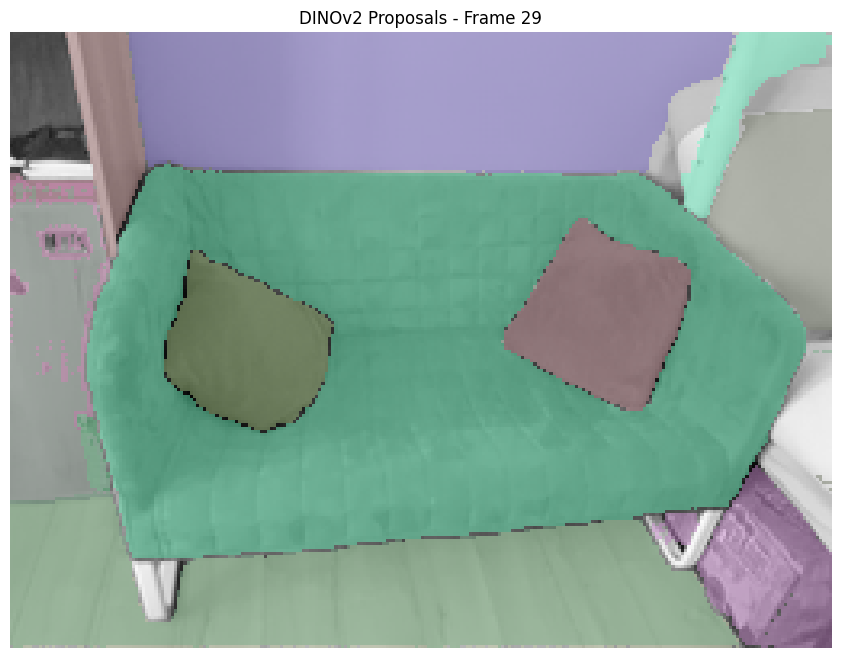

In [11]:
example_results = visualize_project_example_dino(
    config,
    frame_index=config.PROJECT_CONFIG['example_viz_index']
)

## 3D bounding box + centroid for object location

To save the position of the object, we are going to create a 3D bounding box and also save the centroid ob the object based on the depth given by the dataset. With the camera parameters and the depth, we can project the positon from the 2D image to the 3D world space. This are the steps:


1. **Filter valid points**  
   Keep only the pixel coordinates and depth values that are marked as valid.  

2. **Extract camera intrinsics**  
   - `fx, fy`: focal lengths in the x and y directions.  
   - `cx, cy`: principal point (optical center) of the camera.  

3. **Back-project pixels into camera space**  
   Convert 2D image coordinates `(u, v)` + depth `z` into 3D camera coordinates:  

  $$
   x = \frac{(u - cx) \cdot z}{fx}, \quad
   y = \frac{(v - cy) \cdot z}{fy}, \quad
   z = z
   $$

4. **Transform to world coordinates**  
   - Form homogeneous coordinates (add a 1).  
   - Multiply by `camera_pose` to map from the camera frame → world frame.  

5. **Compute compact representations**  
   - **Centroid**: mean position of all 3D points.  
   - **Bounding box**: min and max values along each axis (axis-aligned bounding box in world coordinates).  

In [12]:
def extract_3d_position_from_mask(
    mask: np.ndarray,
    depth_image: np.ndarray,
    camera_intrinsics: np.ndarray,
    camera_pose: np.ndarray,
    depth_scale: float,
    max_points: int = 500
) -> dict:
    """
    Convert a binary mask into compact 3D object representation:
    centroid + bounding box in world coordinates.

    Args:
        mask: Binary segmentation mask (H,W)
        depth_image: Depth map aligned with RGB (H,W), uint16 or float
        camera_intrinsics
        camera_pose
        depth_scale: scale factor for depth values
        max_points: number of pixels to sample from mask

    Returns:
        dict with 'centroid' and 'bbox_3d', or None if invalid
    """
    coords = np.column_stack(np.where(mask))  # (y, x) pixel indices
    if coords.shape[0] < 20:
        return None

    # Sample pixels if mask too large
    sample_idx = np.random.choice(len(coords), min(max_points, len(coords)), replace=False)
    coords = coords[sample_idx]

    # Depth values
    z = depth_image[coords[:, 0], coords[:, 1]].astype(np.float32) / depth_scale
    valid = z > 0
    if not np.any(valid):
        return None

    coords = coords[valid]
    z = z[valid]

    # Get camera parameters
    fx, fy = camera_intrinsics[0, 0], camera_intrinsics[1, 1]
    cx, cy = camera_intrinsics[0, 2], camera_intrinsics[1, 2]
    
    x = (coords[:, 1] - cx) * z / fx
    y = (coords[:, 0] - cy) * z / fy
    pts_cam = np.stack([x, y, z], axis=-1)

    # Camera → World
    pts_h = np.concatenate([pts_cam, np.ones((pts_cam.shape[0], 1))], axis=-1).T
    pts_world = (camera_pose @ pts_h)[:3].T

    # Compact representation
    centroid = pts_world.mean(axis=0)
    bbox_min = pts_world.min(axis=0)
    bbox_max = pts_world.max(axis=0)

    return {
        'centroid': centroid,
        'bbox_3d': np.stack([bbox_min, bbox_max])
    }


## Frame Processing


Now we want to do this for each frame. Each frame:
- SAM
- DINOv2
- 3D bounding box + centroid (position tracking)

In [13]:
def process_frame_project(frame_data: Dict,
        sam_model, sam_processor,
        dino_model, dino_processor,
        device: str,
        config: Config,
        grid_size: int = 6) -> Dict:
    """Process a single frame for Project: SAM proposals + DINOv2 features."""
    results = {
    'frame_name': frame_data['frame_name'],
    'objects': []
}
    try:
        # Load images
        image = Image.open(frame_data['rgb_path']).convert("RGB")
        depth_image = cv2.imread(frame_data['depth_path'], cv2.IMREAD_UNCHANGED)
        rgb_image = np.array(image)
        
        # Generate SAM proposals
        proposals = generate_sam_proposals_project(
            image,
            sam_model,
            sam_processor,
            device,
            grid_size=grid_size,
            confidence_threshold=config.PROJECT_CONFIG['sam_confidence_threshold']
        )
        
        # Process each proposal
        for proposal in proposals:
            mask = proposal['mask']
            
            # Extract DINOv2 features
            dino_features = extract_dino_features_from_segment(
                image,
                mask,
                dino_model,
                dino_processor,
                device,
                padding_ratio=config.PROJECT_CONFIG['padding_ratio_image_crops'] 
            )
            
            if dino_features is None:
                print("No DINO features!")
                continue
            
            # Get compact 3D position (Bounding 3D box + Centroid)
            pos_data = extract_3d_position_from_mask(
                mask,
                depth_image,
                frame_data['camera_intrinsics'],
                frame_data['camera_pose'],
                config.TSDF_CONFIG['depth_scale']
            )
            if pos_data is None:
                print("No pos data!")
                continue
            
            results['objects'].append({
                'features': dino_features,
                'centroid': pos_data['centroid'],
                'bbox_3d': pos_data['bbox_3d'],
                'area_px': proposal['area'],
                'confidence': proposal['confidence']
            })
            
    except Exception as e:
        print(f"Error processing frame {frame_data['frame_name']}: {e}")

    return results


## Tracking through images

### Get frame list
In this function we are simply choosing which frames we want to track through, based on a starting frame, a frame skip, and a maximum number of frames. For the code right now, we start in a specific image from the same scene as Lab2 (one where the sofa is visible, it was chosen consciously), and track the next 25 frames.

In [14]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from lab_utils.data_utils import load_camera_poses, load_camera_intrinsics

camera_poses = load_camera_poses(config.TRAJ_FILE_PATH)

def get_frame_list(config, frame_skip=1, max_frames=25, start_frame_name = None):
    files = sorted(os.listdir(config.RGB_PATH))
    frames = []

     # If start_frame_name is provided, find its index
    if start_frame_name is not None:
        try:
            start_idx = next(i for i, f in enumerate(files) if f == start_frame_name)
            files = files[start_idx:]  # start from that frame
        except StopIteration:
            raise ValueError(f"Start frame {start_frame_name} not found in {config.RGB_PATH}")

    for i, f in enumerate(files[::frame_skip]):
        if i >= max_frames:
            break

        timestamp = os.path.splitext(f)[0]

        # Load intrinsics for this frame
        try:
            K, image_size = load_camera_intrinsics(config.INTRINSICS_PATH, f)
        except Exception as e:
            print(f"Skipping {f}, failed to load intrinsics: {e}")
            continue

        # Load camera pose
        pose = camera_poses.get(timestamp, np.eye(4))

        frames.append({
            "frame_name": f,
            "timestamp": timestamp,
            "rgb_path": os.path.join(config.RGB_PATH, f),
            "depth_path": os.path.join(config.DEPTH_PATH, f.replace(".jpg", ".png")),
            "camera_intrinsics": K,
            "intrinsics_size": image_size,
            "camera_pose": pose
        })

    return frames


Loaded 540 camera poses


### Project 3D points

Here it's a simple function to transform the 3D points to 2D just for visualization purposes, to obtain a 2D bounding box. Again, this is just to visualize which object we are tracking.

In [15]:
def project_points(K, points_3d):
    uv_coords = []
    for X, Y, Z in points_3d:
        if Z > 0:
            uv = K @ np.array([X, Y, Z])
            u, v = uv[0] / uv[2], uv[1] / uv[2]
            uv_coords.append((u, v))
    return uv_coords

### Run scene
Now we are ready to track an object through frames. We will also use a slider to show all the frames with a 2D bounding box following said object. In this case we are tracking a random object because again, no text input. For comparing features we are using the cosine similarity.

Then, we proceed to draw the 2D bounding box.

In [28]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import cm


def run_scene_tracking_slider(config, n_frames = 30):
    """
    Interactive slider to visualize tracking of a specific object across frames using DINO.
    """
    # Load models
    sam_model, sam_processor, device = load_sam_model(model_size='base')
    dino_model, dino_processor, _ = load_dino_model(device=device)

    # Get frame metadata
    frames_metadata = get_frame_list(config, frame_skip=1, max_frames = n_frames, start_frame_name="47333473_58547.751.png")

    processed_frames = []

    # Placeholder for the DINO features of the object to track
    target_features = None

    print(f"Processing frames ...")
    for idx, frame_data in enumerate(frames_metadata):
        # Process each frame
        results = process_frame_project(frame_data, sam_model, sam_processor, dino_model, dino_processor, device, config)

        frame = Image.open(frame_data['rgb_path']).convert("RGB")
        overlay = frame.convert('RGBA')
        draw = ImageDraw.Draw(overlay, 'RGBA')

        if not results['objects']:
            # No objects detected in this frame
            processed_frames.append(overlay)
            continue

        if target_features is None:
            # First frame: pick an object (random since no text input)
            target_features = results['objects'][4]['features']

        # Find object most similar to target  and threshold it to make sure we are not tracking another one just because it is the best
        best_idx = None
        best_sim = 0.0
        similarity_threshold = 0.6  # tweak based on your data

        for i, obj in enumerate(results['objects']):
            features = obj['features']
            sim = np.dot(target_features, features) / (np.linalg.norm(target_features) * np.linalg.norm(features) + 1e-8)
            if sim > best_sim:
                best_sim = sim
                if sim >= similarity_threshold:
                    best_idx = i


       # Draw bounding box or mask     
        if best_idx is not None:
            obj = results['objects'][best_idx]
            bbox_3d = obj['bbox_3d']
            centroid = obj['centroid']

            points_2d = project_points(frame_data['camera_intrinsics'], obj['bbox_3d'])
            if points_2d:
                xs, ys = zip(*points_2d)
                x0, x1 = int(min(xs)), int(max(xs))
                y0, y1 = int(min(ys)), int(max(ys))
                draw.rectangle([x0, y0, x1, y1], outline=(255,0,0,180), width=3)


        processed_frames.append(overlay)

    # Slider widget
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(processed_frames)-1,
        step=1,
        description='Frame'
    )
    out = widgets.Output()

    def show_frame(change):
        idx = change['new']
        with out:
            clear_output(wait=True)
            display(processed_frames[idx])

    slider.observe(show_frame, names='value')
    display(widgets.VBox([slider, out]))

    return processed_frames

In [29]:
# Run full pipeline
run_scene_tracking_slider(config, n_frames=25)

Loading SAM model (base)...
SAM model loaded on device: cuda
Loading DINOv2 model: facebook/dinov2-base...
DINOv2 model loaded on device: cuda
Processing frames ...
Generating SAM proposals with 6x6 grid...
Generated 8 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 7 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 10 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 10 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 9 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 14 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 13 unique segment proposals
Generating SAM proposals with 6x6 grid...
Generated 13 unique segment proposals
Generating SAM proposals with 6x6 grid..

[<PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image image mode=RGBA size=256x192>,
 <PIL.Image.Image im